In [1]:
import os
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import math
from LatLongUTMconversion import LLtoUTM, UTMtoLL
import mission_plan_v2 as mp


In [44]:
# Function definitions
def dist_2points(x1, y1, x2, y2):
    distance = math.sqrt(((x1-x2)**2)+((y1-y2)**2))
    return distance

def cal_slope(sp, ep):
    lane_slope = (sp[1] - ep[1]) / (sp[0] - ep[0])
    line_slope = -1/lane_slope
    return(lane_slope, line_slope)

# lane_c_utm_sp = get_offset_coords(lane_le_utm_sp[0], lane_le_utm_sp[1], slope_le[1], road_w/2, path_dir)

# input: utm info >> output : utm info
def get_offset_coords(x, y, slope, dist, path_dir):
    if path_dir == 1:     # Westbound
        new_x = x + dist*math.sqrt( 1/(1+math.pow(slope,2)) )
        new_y = y - slope*dist*math.sqrt( 1/(1+math.pow(slope,2)) )
    else:                 # Eastbound -------- NEED TO BE FIXED
        new_x = x + dist*math.sqrt( 1/(1+math.pow(slope,2)) )
        new_y = y + slope*dist*math.sqrt( 1/(1+math.pow(slope,2)) )
    return(new_x,new_y)

# input: utm info >> output: gps info
# sp and ep is from the center line of the lane.
# (+) is right side of the line.

def get_mission_utm_wp(sp_x, sp_y, ep_x, ep_y, slope, offset1, offset2):
    sp_x1 = sp_x + offset1*math.sqrt( 1/(1+math.pow(slope,2)) )
    sp_y1 = sp_y + slope*offset1*math.sqrt( 1/(1+math.pow(slope,2)) )
    
    ep_x1 = ep_x + offset1*math.sqrt( 1/(1+math.pow(slope,2)) )
    ep_y1 = ep_y + slope*offset1*math.sqrt( 1/(1+math.pow(slope,2)) )
    
    ep_x2 = ep_x + offset2*math.sqrt( 1/(1+math.pow(slope,2)) )
    ep_y2 = ep_y + slope*offset2*math.sqrt( 1/(1+math.pow(slope,2)) )
    
    sp_x2 = sp_x + offset2*math.sqrt( 1/(1+math.pow(slope,2)) )
    sp_y2 = sp_y + slope*offset2*math.sqrt( 1/(1+math.pow(slope,2)) )
    
    return([sp_x1,sp_y1],[ep_x1,ep_y1],[ep_x2,ep_y2],[sp_x2,sp_y2])


#M_wp_utm.append(get_mission_utm_wp(lane_c_utm_sp[0], lane_c_utm_sp[1], lane_c_utm_ep[0], lane_c_utm_ep[1],
#                                       slope_le[1], d_offset[i], -d_offset[i]-road_w))

#M_wp.append(get_mission_wp(utm_zone, M_wp_utm[i][0], M_wp_utm[i][1], M_wp_utm[i][2], M_wp_utm[i][3]))

    
# UTM -> GPS
def get_mission_wp(zone, sp1, ep1, ep2, sp2):
    pnt_M = [UTMtoLL(23, sp1[1], sp1[0], zone), UTMtoLL(23, ep1[1], ep1[0], zone),
             UTMtoLL(23, ep2[1], ep2[0], zone), UTMtoLL(23, sp2[1], sp2[0], zone)]
    return(pnt_M)

def dist_2points_ll(lat1, lon1, lat2, lon2):
    (zone,x1,y1)=LLtoUTM(23, lat1, lon1)
    (zone,x2,y2)=LLtoUTM(23, lat2, lon2)
    distance = math.sqrt(((x1-x2)**2)+((y1-y2)**2))
    return distance

# Calculate required altitude for forward camera direction
def cal_alt_f(cam_mount_angle, cam_fov, d_scan):
    # For Forward camera direction
    cam_mount_angle_rad = (cam_mount_angle*math.pi/180)     # in radian
    cam_fov_rad = (cam_fov*math.pi/180)                     # in radian
    alt_req_f = d_scan * math.sin(cam_mount_angle_rad) / (2* math.tan(cam_fov_rad/2))
    return alt_req_f

# Calculate required altitude for perpendicular camera direction
def cal_alt_p(cam_mount_angle, cam_fov, d_scan):
    angle_far = (90 - cam_mount_angle + cam_fov/2)     # in degrees
    angle_near = (90 - cam_mount_angle - cam_fov/2)    # in degrees
    angle_far_rad = (angle_far*math.pi/180)            # in radian
    angle_near_rad = (angle_near*math.pi/180)          # in radian
    # d_scan = altitude * (math.tan(angle_far_rad) - math.tan(angle_near_rad))
    alt_req_p = d_scan / (math.tan(angle_far_rad) - math.tan(angle_near_rad))
    return alt_req_p

def cal_d_near(cam_mount_angle, cam_fov, alt):
    angle_near = (90 - cam_mount_angle - cam_fov/2)    # in degrees
    angle_near_rad = (angle_near*math.pi/180)          # in radian
    d_near = alt * math.tan(angle_near_rad)            # from the camera to the first fixel of image plane
    return d_near

In [45]:
# utm zone
usma_zone = '18T'
ypg_zone = '11S'

utm_zone = ypg_zone

# Left Edge of the lane
lane_le_sp = [41.3907283,-73.9533754]
lane_le_ep = [41.3911509,-73.9531656]


## YPG L70 Eastbound : West ->(A-B-C)-> East
# L70A Left Edge - 600m
lane_le_sp = [32.8486350,-114.2733560]
lane_le_ep = [32.8486539,-114.2669326]
# L70B Left Edge - 640m
lane_le_sp = [32.8486590,-114.2668704]
lane_le_ep = [32.8486834,-114.2600198]
# L70C Left Edge - 630m
lane_le_sp = [32.8486890,-114.2599380]
lane_le_ep = [32.8487088,-114.2531950]

## YPG L70 Westbound : West <-(A-B-C)<- East
# L70C Left Edge - 630m
lane_le_sp = [32.8485748,-114.2531950]
lane_le_ep = [32.8485455,-114.2599337]
# L70B Left Edge - 640m
lane_le_sp = [32.8485439,-114.2600198]
lane_le_ep = [32.8485226,-114.2668713]
# L70A Left Edge - 600m
lane_le_sp = [32.8485203,-114.2669326]
lane_le_ep = [32.8484932,-114.2733557]


# Input
lane_le_sp = [32.8486747,-114.2711161]
lane_le_ep = [32.8487354,-114.2594498]


# L70A Left Edge - 600m Eastbound
lane_le_sp = [32.8485748,-114.2531950]
lane_le_ep = [32.8485455,-114.2599337]

# Flight direction
# Westbound is positive 1
# Eastbound is -1
path_dir = 1

# INPUT: Left Edge info
# OUTPUT: Center and Right Edge info (with road_w parameter)

In [46]:
# Convert line coords to UTM and show distance
(zone,easting,northing)=LLtoUTM(23, lane_le_sp[0], lane_le_sp[1])
lane_le_utm_sp = (easting,northing)

(zone,easting,northing)=LLtoUTM(23, lane_le_ep[0], lane_le_ep[1])
lane_le_utm_ep = (easting,northing)

print("Zone: " + str(zone))
print("Line start point: " + str(lane_le_utm_sp))
print("Line  end  point: " + str(lane_le_utm_ep))
dist = dist_2points(lane_le_utm_sp[0], lane_le_utm_sp[1], lane_le_utm_ep[0], lane_le_utm_ep[1]) 
print("Distance between 2 points is: %8.2f m" % (dist))

Zone: 11S
Line start point: (757073.3348708146, 3637844.172444776)
Line  end  point: (756442.5450825874, 3637824.524947249)
Distance between 2 points is:   631.10 m


In [47]:
# Compute slope and perpendicular slope
slope_le = cal_slope(lane_le_utm_sp, lane_le_utm_ep)
#print("The slope of the lane is:   %8.4f \nThe perpendicular slope is: %8.4f" % (slope_le[0], slope_le[1]))

yaw = 2*math.pi - math.atan(slope_le[0])   # slope_le angle is from positive x-axis (CCW)
yaw_deg = yaw*180/math.pi
yaw_deg = yaw_deg + 90   # QGC 0 deg is positive y-axis (CW)

#print(lane_le_sp)
#print(lane_le_ep)

if lane_le_sp[1] > lane_le_ep[1]:
    yaw_deg = yaw_deg + 180
    path_dir = 1

while yaw_deg >= 360:
    yaw_deg = yaw_deg - 360
    
print(path_dir)
print("Yaw in degrees: %8.2f deg." % (yaw_deg))

1
Yaw in degrees:   268.22 deg.


In [48]:
# Camera parameters
cam_mount_angle = 45.0    # in degrees
cam_fov = 35.0         # in degrees
# GOBI_FOV: 35 deg.
# FLIR_FOV: 60 deg.

# Road Width
road_w = 15.0

# Compute SP and EP of the Center of the lane
lane_c_utm_sp = get_offset_coords(lane_le_utm_sp[0], lane_le_utm_sp[1], slope_le[1], road_w/2, path_dir)
lane_c_utm_ep = get_offset_coords(lane_le_utm_ep[0], lane_le_utm_ep[1], slope_le[1], road_w/2, path_dir)
lane_c_sp = UTMtoLL(23, lane_c_utm_sp[1], lane_c_utm_sp[0], utm_zone)
lane_c_ep = UTMtoLL(23, lane_c_utm_ep[1], lane_c_utm_ep[0], utm_zone)
# Compute SP and EP of the Right Edge of the lane
lane_re_utm_sp = get_offset_coords(lane_le_utm_sp[0], lane_le_utm_sp[1], slope_le[1], road_w, path_dir)
lane_re_utm_ep = get_offset_coords(lane_le_utm_ep[0], lane_le_utm_ep[1], slope_le[1], road_w, path_dir)
lane_re_sp = UTMtoLL(23, lane_re_utm_sp[1], lane_re_utm_sp[0], utm_zone)
lane_re_ep = UTMtoLL(23, lane_re_utm_ep[1], lane_re_utm_ep[0], utm_zone)


## ONE SHOT mission order - Left >> Right >> Return to the Left (across the road)
# (*) and (|) represent a quadrotor and a line of the lane, respectively.
# The number which closes to (*) is HPC.
#
# M1: Front - Left outer edge of the lane (10|5)
# M2: Perpendicular - Left edge of the lane (*5|10) > (10|5*)
# M3: Front - Center of the lane (10|15|10)
# M4: Perpendicular - Right edge of the lane (*5|10) > (10|5*)
# M5: Front - Right outer edge of the lane (5|10)
# M6: Perpendicular - Across the lane (10|25|*) > (*|25|10)

# M1
HLPC01 = [str("F"),str("L"),10.0,5.0]  # 10m off the road / 5m on the road
# M2
HLPC02 = [str("P"),str("L"),5.0,10.0]
# M3
HLPC03 = [str("F"),str("C"),10.0,15.0,10.0]
# M4
HLPC04 = [str("P"),str("R"),5.0,10.0]
# M5
HLPC05 = [str("F"),str("R"),10.0,5.0]  # 10m off the road / 5m on the road
# M6
HLPC06 = [str("P"),str("A"),10.0,25.0] # 10m off the road / 25m across the road

## One Mission
HLPC_ONE = [str("P"),str("R"),10.0,10.0]


## YPG Missions
HLPC_manual_p = [str("P"), str("L"), 10.0, 5.0]

HLPC_manual_f = [str("F"), str("R"), 10.0, 5.0]
HLPC_manual_c = [str("F"), str("C"), 10.0, 15.0, 10.0]


## L and R are inverted for Perpendicular.
## That is, L is for R, R is for L
## off and on should be switched.

## Mission List
#HLPC = HLPC_ONE
#HLPC = [HLPC01,HLPC02,HLPC06]
HLPC = [HLPC_manual_p]

# Lane information
print("Left Edge")
print(lane_le_sp)
print(lane_le_ep)
print("======")
print("Center Line")
print(lane_c_sp)
print(lane_c_ep)
print("======")
print("Right Edge")
print(lane_re_sp)
print(lane_re_ep)

Left Edge
[32.8485748, -114.253195]
[32.8485455, -114.2599337]
Center Line
(32.8486423, -114.2531904)
(32.848613, -114.2599291)
Right Edge
(32.8487098, -114.2531858)
(32.8486805, -114.2599246)


In [49]:
# Altitude for scanning required width
alt = []
# Offset distance from "The CENTER of the LANE" for scanning required HPC/LPC
# (+) is for the right side, (-) is for the left side from the center of the lane
d_offset = []

M_wp_utm = []
M_wp = []
for i in range(len(HLPC)):
    d_scan = sum(HLPC[i][2:len(HLPC[i])])    
    if HLPC[i][0] == str("F"):     # Forward camera direction
        # Compute the require altitude for scanning HPC+LPC with Forward camera direction
        alt.append(cal_alt_f(cam_mount_angle, cam_fov, d_scan))
        # Align the path - Compute offset distance
        if HLPC[i][1] == str("L"):     # Left edge
            d_offset.append(d_scan/2 - HLPC[i][2] - road_w/2)
        elif HLPC[i][1] == str("R"):   # Right edge
            d_offset.append(-d_scan/2 + HLPC[i][2] + road_w/2 )
        else:                          # Center
            d_offset.append(0)            
        # Save mission waypoints in UTM and GPS protocol
        M_wp_utm.append(get_mission_utm_wp(lane_c_utm_sp[0], lane_c_utm_sp[1],
                                   lane_c_utm_ep[0], lane_c_utm_ep[1],
                                   slope_le[1], d_offset[i], d_offset[i]))
        M_wp.append(get_mission_wp(utm_zone, M_wp_utm[i][0], M_wp_utm[i][1], M_wp_utm[i][2], M_wp_utm[i][3]))

    else:                          # Perpendicular camera direction
        # Compute the require altitude for scanning HPC+LPC with Perpendicular camera direction
        alt.append(cal_alt_p(cam_mount_angle, cam_fov, d_scan))
        d_near = cal_d_near(cam_mount_angle, cam_fov, alt[i])
        # Align the path - Compute offset distance
        # cal_d_near: compute the distance between the camera and the closest image pixel from the camera
        if HLPC[i][1] == str("L"):     # Left edge (fly from left to right)
            d_offset.append(-HLPC[i][2] - road_w/2 - d_near)
            # Save mission waypoints in UTM and GPS protocol
            M_wp_utm.append(get_mission_utm_wp(lane_c_utm_sp[0], lane_c_utm_sp[1],
                                       lane_c_utm_ep[0], lane_c_utm_ep[1],
                                       slope_le[1], d_offset[i], d_offset[i]+d_scan+2*d_near))
            M_wp.append(get_mission_wp(utm_zone, M_wp_utm[i][0], M_wp_utm[i][1], M_wp_utm[i][2], M_wp_utm[i][3]))

        elif HLPC[i][1] == str("R"):   # Right edge (fly from left to right)
            d_offset.append(road_w/2 - HLPC[i][3] - d_near)
            # Save mission waypoints in UTM and GPS protocol
            M_wp_utm.append(get_mission_utm_wp(lane_c_utm_sp[0], lane_c_utm_sp[1],
                                       lane_c_utm_ep[0], lane_c_utm_ep[1],
                                       slope_le[1], d_offset[i], d_offset[i]+d_scan+2*d_near))
            M_wp.append(get_mission_wp(utm_zone, M_wp_utm[i][0], M_wp_utm[i][1], M_wp_utm[i][2], M_wp_utm[i][3]))

        else:                          # Across the lane (fly from left to right)
            d_offset.append(-road_w/2 - HLPC[i][2] - d_near)
            # Save mission waypoints in UTM and GPS protocol
            M_wp_utm.append(get_mission_utm_wp(lane_c_utm_sp[0], lane_c_utm_sp[1],
                                       lane_c_utm_ep[0], lane_c_utm_ep[1],
                                       slope_le[1], d_offset[i], -d_offset[i])-HLPC[i][2]+HLPC[i][4])
            M_wp.append(get_mission_wp(utm_zone, M_wp_utm[i][0], M_wp_utm[i][1], M_wp_utm[i][2], M_wp_utm[i][3]))
  
            
# output
# alt: the required altitude for scanning (HPC+LPC) with the preset camera direction
# d_offset: the distance between the center line of the road and the camera
# M_wp: Mission points

print("road width = %3.1f m" %road_w)
print("OFF road = %3.1f m / ON road = %3.1f m" %(HLPC[i][2],HLPC[i][3]))
print("d_near = %8.3f m" %d_near)
print("d_scan = %8.3f m" %d_scan)
print("====")
print("d_offset",d_offset)
print("alt",alt)

road width = 15.0 m
OFF road = 10.0 m / ON road = 5.0 m
d_near =    5.576 m
d_scan =   15.000 m
====
('d_offset', [-23.07585096715824])
('alt', [10.711110050565864])


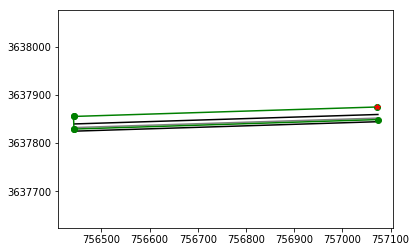

In [50]:
plt.figure(1)
#plt.gca().add_line(mlines.Line2D([lane1_sp[0],lane1_sp[1]], [lane1_ep[0],lane1_ep[1]]))
# Plot Road - Left/Right Edges and Center of the Road
plt.plot([lane_c_utm_sp[0],lane_c_utm_ep[0]], [lane_c_utm_sp[1],lane_c_utm_ep[1]], color='grey')
plt.plot([lane_le_utm_sp[0],lane_le_utm_ep[0]], [lane_le_utm_sp[1],lane_le_utm_ep[1]], color='k')
plt.plot([lane_re_utm_sp[0],lane_re_utm_ep[0]], [lane_re_utm_sp[1],lane_re_utm_ep[1]], color='k')

for i in range(len(HLPC)):
    plt.plot([M_wp_utm[i][0][0],M_wp_utm[i][1][0]], [M_wp_utm[i][0][1],M_wp_utm[i][1][1]],
             marker='o', color='green')
    plt.plot([M_wp_utm[i][1][0],M_wp_utm[i][2][0]], [M_wp_utm[i][1][1],M_wp_utm[i][2][1]],
             marker='o', color='green')
    plt.plot([M_wp_utm[i][2][0],M_wp_utm[i][3][0]], [M_wp_utm[i][2][1],M_wp_utm[i][3][1]],
             marker='o', color='green')
    # Plot Starting Points of each mission
    plt.plot(M_wp_utm[i][0][0],M_wp_utm[i][0][1], 'r*')
    
plt.axis('equal');

In [51]:
# Two points difference
check_pt1 = [lane_le_sp[0],lane_le_sp[1]]
#check_pt1 = [41.3907377, -73.9534922]
check_pt2 = [M_wp[0][0][0],M_wp[0][0][1]]

#wp1:(41.3906877, -73.9533228)
#wp2:(41.3915149, -73.952892)
#wp3:(41.3915649, -73.9530614)
#wp4:(41.3907377, -73.9534922)

print("=== from (le_sp) to (WP01) ===")
print("\nThe distance between two points is %8.3f m\n" \
      % (dist_2points_ll(check_pt1[0],check_pt1[1],check_pt2[0],check_pt2[1])))

=== from (le_sp) to (WP01) ===

The distance between two points is   30.568 m



In [52]:
# QGC Mission Generation
speed = 5.0             # m/s
alt_limit = 50          # m

sp_lane1 = [lane_le_sp[0],lane_le_sp[1],alt,3]
ep_lane1 = [lane_le_ep[0],lane_le_ep[1],alt,3]

# RTK points - Alt is set to 10 meters
rtk_pt1 = [41.390651194,-73.953278861,10,3]
rtk_pt2 = [41.390823944,-73.953626667,10,3]
rtk_pt3 = [41.391267139,-73.953483611,10,3]
rtk_pt4 = [41.390525194,-73.953372389,10,3]


## Mission Protocol
# "16" is MAV_CMD_NAV_WAYPOINT: [lat, log, alt, hold]

# "20" is MAV_CMD_RTL: [20]
# In Ardupilot, the parameter "RTL_ALT_FINAL" should be set for return altitude
# RTL_ALT_FINAL = 0 ~ 1000 centimeters
# RTL_ALT_FINAL = 0 >> Autonomous landing

# "21" is MAV_CMD_LANDING: [21, lat, log, alt]

# "115" is MAV_CMD_CONDITION_YAW: [115, rot_angle, value] - If (rot_angle) is negative, then it rotates CCW.
# (value) = 0 is for Absolute, (value) = 1 is for Relative.

# "178" is MAV_CMD_DO_CHANGE_SPEED: [178, speed]


dummy = 0
rot = 1
M_input = []
for i in range(len(M_wp)):
    # Limit altitude
    if alt[i] > alt_limit:
        alt[i] = alt_limit
        
    if HLPC[i][0] == str("F"):     # Forward
        wp1 = [M_wp[i][0][0],M_wp[i][0][1],alt[i],3]
        wp2 = [M_wp[i][1][0],M_wp[i][1][1],alt[i],3]
        wp3 = [M_wp[i][2][0],M_wp[i][2][1],alt[i],1]
        wp4 = [M_wp[i][2][0],M_wp[i][2][1],alt[i],5]
        wp5 = [M_wp[i][3][0],M_wp[i][3][1],alt[i],3] 
        M_input = M_input + [[115,yaw_deg,dummy],wp1,[178,speed,dummy],wp2,[178,speed,dummy],wp3,[115,-180,rot],wp4,wp5]
    else:                          # Perpendicular
        wp1 = [M_wp[i][0][0],M_wp[i][0][1],alt[i],3]
        wp2 = [M_wp[i][1][0],M_wp[i][1][1],alt[i],3]
        wp3 = [M_wp[i][2][0],M_wp[i][2][1],alt[i],3]
        wp4 = [M_wp[i][2][0],M_wp[i][2][1],alt[i],5]
        wp5 = [M_wp[i][3][0],M_wp[i][3][1],alt[i],3]
#        if i == len(M_wp)-1:
#            rot = -1
#            yaw_deg_p = yaw_deg - 90
#        else:
#            yaw_deg_p = yaw_deg + 90
        if path_dir == -1:
            yaw_deg_p = yaw_deg + 90
            yaw_deg_p2 = yaw_deg_p + 180
        else:
            yaw_deg_p = yaw_deg - 90
            yaw_deg_p2 = yaw_deg_p + 180
        while yaw_deg_p >= 360:
            yaw_deg_p = yaw_deg_p - 360
        while yaw_deg_p2 >= 360:
            yaw_deg_p2 = yaw_deg_p2 - 360
#        M_input = M_input + [[115,yaw_deg_p,dummy],wp1,[178,speed,dummy],wp2,[178,2.5,dummy],wp3,[115,180*rot,1],wp4,wp5]
        M_input = M_input + [[115,yaw_deg_p,dummy],wp1,[178,speed,dummy],wp2,wp3,[115,yaw_deg_p2,dummy],wp4,wp5]

# Landing mode        
landing_pt = [21, lane_c_sp[0], lane_c_sp[1], 0]

# End mission with RTL mode
# Set "RTL_ALT_FINAL" to 0 for autonomous landing from the Ardupilot parameter side
#M_input = M_input + [[20]]     # 20 is MAV_CMD_RTL: [20]


# Generate QGC Mission
with open('bhg_flight_v2.plan', 'w') as f:
    plan = mp.make_plan(M_input,speed)
    #print(plan)
    f.write(plan)

print("\n++ New flight plan is generated!!\n")
print("Target altitude is %8.3f" %alt[0])
if path_dir == 1:
    print("Westbound trip")
else:
    print("Eastbound trip")


++ New flight plan is generated!!

Target altitude is   10.711
Westbound trip
